In [1]:
import json

# Initial Data Processing

`gps_20161201` has a lot of redundant information that makes it very large uncompressed. Let's make it more concise.

In [2]:
# process datafile into nicer, more concise format
with open('gps_20161201') as f:
    i = 0
    order_ids = {}
    data = {}
    print('Header: ', f.readline().split(',')) # skip header row
    
    l = f.readline()
    while l:
        l = l.split(',')
        
        # encode long order_ids as shorter indices
        if l[1] not in order_ids:
            order_ids[l[1]] = i
            i += 1
        
        row = {
                't': int(l[2]),
                'lon': float(l[3]),
                'lat': float(l[4])
        }
        
        if order_ids[l[1]] not in data:
            data[order_ids[l[1]]] = [row]
        else:
            data[order_ids[l[1]]].append(row)
        l = f.readline()

del order_ids
print('Unique orders: ', len(data))

# save processed data to file
with open('gps_20161201_mod.json', 'w') as f:
    f.write(json.dumps(data))

Header:  ['driver_id', 'order_id', 'timestamp', 'longitude', 'latitude\n']
Unique orders:  111541


In [17]:
# skip constructing the file again
with open('gps_20161201_mod.json', 'r') as f:
    data = json.load(f)
data = {int(k):v for k,v in data.items()}

# Checking Timestamp and Lat/Long distribution

In [21]:
ts = []
lat_range = [data[0][0]['lat'], data[0][0]['lat']]
lon_range = [data[0][0]['lon'], data[0][0]['lon']]

for _,order in data.items():
    for p in order:
        
        # track ts for histogram making
        ts.append(p['t'])
        
        if p['lat'] < lat_range[0]:
            lat_range[0] = p['lat']
        if p['lat'] > lat_range[1]:
            lat_range[1] = p['lat']
        
        if p['lon'] < lon_range[0]:
            lon_range[0] = p['lon']
        if p['lon'] > lon_range[1]:
            lon_range[1] = p['lon']

print(lat_range)
print(lon_range)

[34.20531, 34.28021]
[108.91119, 108.9986]


Latitude and longitude range looks reasonable. What about timestamps?

In [22]:
from datetime import datetime
print(datetime.utcfromtimestamp(min(ts)))
print(datetime.utcfromtimestamp(max(ts)))

2016-11-30 16:01:37
2016-12-01 16:03:55


Interesting. The data's from 11/30 4 PM to 12/1 4 PM, while we're supposed to predict 12/1 12 AM to 12/2 12 AM.

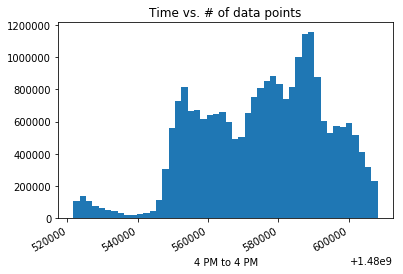

In [25]:
import matplotlib.pyplot as plt

plt.hist(ts,bins=48)
del ts
plt.gcf().autofmt_xdate()
plt.title('Time vs. # of data points')
plt.xlabel('4 PM to 4 PM')
plt.savefig('dist.png')
plt.show()

And we only have a little data from before 12/1 12 AM.

# Geospatial distribution

Let's check where all of our points land.

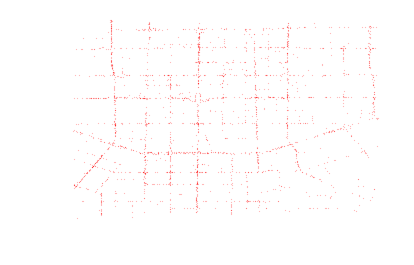

In [26]:
from pyproj import Proj, transform
fig, ax = plt.subplots()

i = 0
for _,order in data.items():
    for pt in order:
        i += 1
        if i % 10_000 == 0:
            cr = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), pt['lon'], pt['lat'])
            ax.plot(cr[0], cr[1], marker='o', markersize='.1', color='red')

plt.axis('off')
plt.show()

In [27]:
from bokeh.plotting import figure, show
from bokeh.tile_providers import CARTODBPOSITRON, STAMEN_TERRAIN, STAMEN_TONER_BACKGROUND
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook

output_notebook()

# find lat/long edges of given data
bl = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lon_range[0], lat_range[0])
ur = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lon_range[1], lat_range[1])

# range bounds supplied in web mercator coordinates
p = figure(x_range = (bl[0], ur[0]),
           y_range = (bl[1], ur[1]),
           x_axis_type="mercator",
           y_axis_type="mercator")
p.add_tile(STAMEN_TONER_BACKGROUND)

# build points
pts = {
    'y': [],
    'x': []
}
i = 0
for _,order in data.items():
    for pt in order:
        i += 1
        if i % 1_000 == 0:
            cr = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), pt['lon'], pt['lat'])
            pts['y'].append(cr[1])
            pts['x'].append(cr[0])
        if i == 10_000:
            print(pt['lat'], pt['lon'])
            print(cr)

# plot points
p.circle(x="x", y="y", size=1, fill_color="red", fill_alpha=1, line_width=0, source=ColumnDataSource(data=pts))


show(p)

Loading BokehJS ...

34.23762 108.92338
(12125295.197082235, 4060753.388753356)


Not sure but I think the basemap is slightly off (as opposed to the points).